In [64]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
selected_issues = [
    "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
				"National Security, Defence, Foreign Affairs", "Veterans and Military"
  ]
df_filtered = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df_filtered.groupby("issue")["text"].count()

issue
Education                                      1411
Energy and Environment                         2380
Health Care and Social Security                2930
Jobs and the Economy                           2333
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

In [ ]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

stop_words_path = "../SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df_filtered.loc[:, "text"] = df_filtered["text"].apply(lambda text: preprocess_text(text, stopwords))
df_filtered = df_filtered[df_filtered["text"] != ""]

In [66]:
topics = {
    "National Security, Defence, Foreign Affairs": 0, 
    "Health Care and Social Security": 1, 
    "Energy and Environment": 2, 
    "Jobs and the Economy": 3,
				"Education": 4, 
				"Veterans and Military": 5, 
}
    

In [75]:
from bertopic import BERTopic
from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction

# Prepare our empty sub-models and reduce frequent words while we are at it.
empty_embedding_model = BaseEmbedder()
empty_dimensionality_model = BaseDimensionalityReduction()
empty_cluster_model = BaseCluster()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        # embedding_model=empty_embedding_model,
        umap_model=empty_dimensionality_model,
        hdbscan_model=empty_cluster_model,
        ctfidf_model=ctfidf_model
)
topics_bert, probs = topic_model.fit_transform(df_filtered["text"], y=list(map(lambda x: topics[x], df_filtered["issue"])))


In [76]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,3673,0_defense_military_security_force,"[defense, military, security, force, president...",[washington dc today congressman joe courtney ...
1,1,2930,1_health_care_patient_drug,"[health, care, patient, drug, medicare, access...",[today congressman jimmy panetta carmel valley...
2,2,2380,2_water_energy_climate_environmental,"[water, energy, climate, environmental, clean,...",[hartford ct today connecticut congressional d...
3,3,2333,3_business_small_job_tax,"[business, small, job, tax, worker, economic, ...",[congresswoman maxine water ca celebrated enac...
4,4,1411,4_student_school_education_college,"[student, school, education, college, loan, hi...",[today representative sharice david vice chair...
5,5,1376,5_veteran_va_service_affair,"[veteran, va, service, affair, military, benef...",[washington dc night congressman joe courtney ...


In [ ]:
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_multiple_issues = df_cleaned[df_cleaned['issue'].str.contains(';')]
df_test = pd.DataFrame(columns=["issue", "text"])
for _, row in df_multiple_issues.iterrows():
   issues = set(row['issue'].split(";"))
   if len(issues) == 1:
       print("sth went wrong")
   else:
       if len(issues.intersection(set(selected_issues))) == 1:
               issue = issues.intersection(set(selected_issues)).pop()
               df_test = df_test._append({"issue": issue, "text": row['text']}, ignore_index=True)

In [78]:
df_test.groupby("issue").count()

,text
issue,
Education,229
Energy and Environment,544
Health Care and Social Security,514
Jobs and the Economy,892
"National Security, Defence, Foreign Affairs",480
Veterans and Military,155


In [79]:
y_pred, y_prob = topic_model.transform(df_test["text"].to_list())

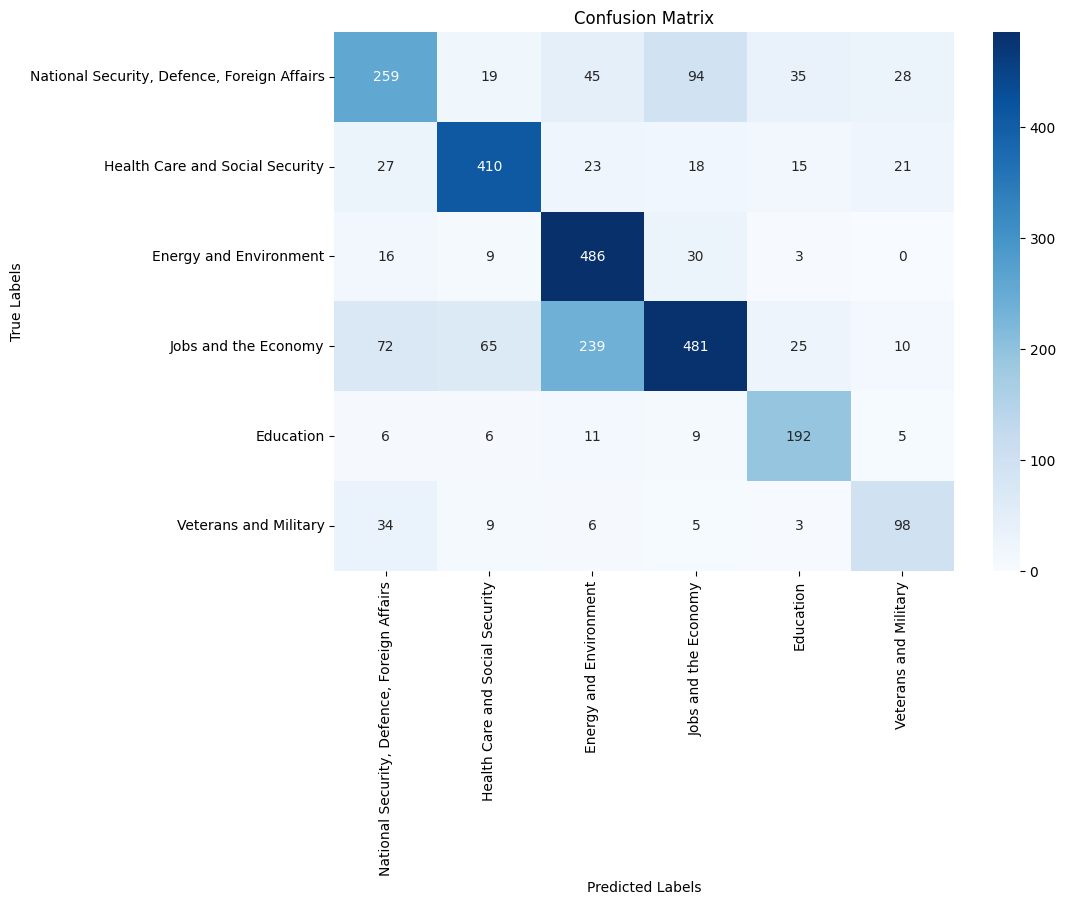

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

predictions = y_pred
ground_truth = list(map(lambda x: topics[x], df_test["issue"].to_list()))

# Generate confusion matrix
cm = confusion_matrix(ground_truth, predictions)

# Display confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=topics.keys(), 
            yticklabels=topics.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [81]:
from sklearn.metrics import classification_report
report = classification_report(ground_truth, predictions, target_names=topics.keys())
print(report)

                                             precision    recall  f1-score   support

National Security, Defence, Foreign Affairs       0.63      0.54      0.58       480
            Health Care and Social Security       0.79      0.80      0.79       514
                     Energy and Environment       0.60      0.89      0.72       544
                       Jobs and the Economy       0.76      0.54      0.63       892
                                  Education       0.70      0.84      0.76       229
                      Veterans and Military       0.60      0.63      0.62       155

                                   accuracy                           0.68      2814
                                  macro avg       0.68      0.71      0.68      2814
                               weighted avg       0.70      0.68      0.68      2814



Train

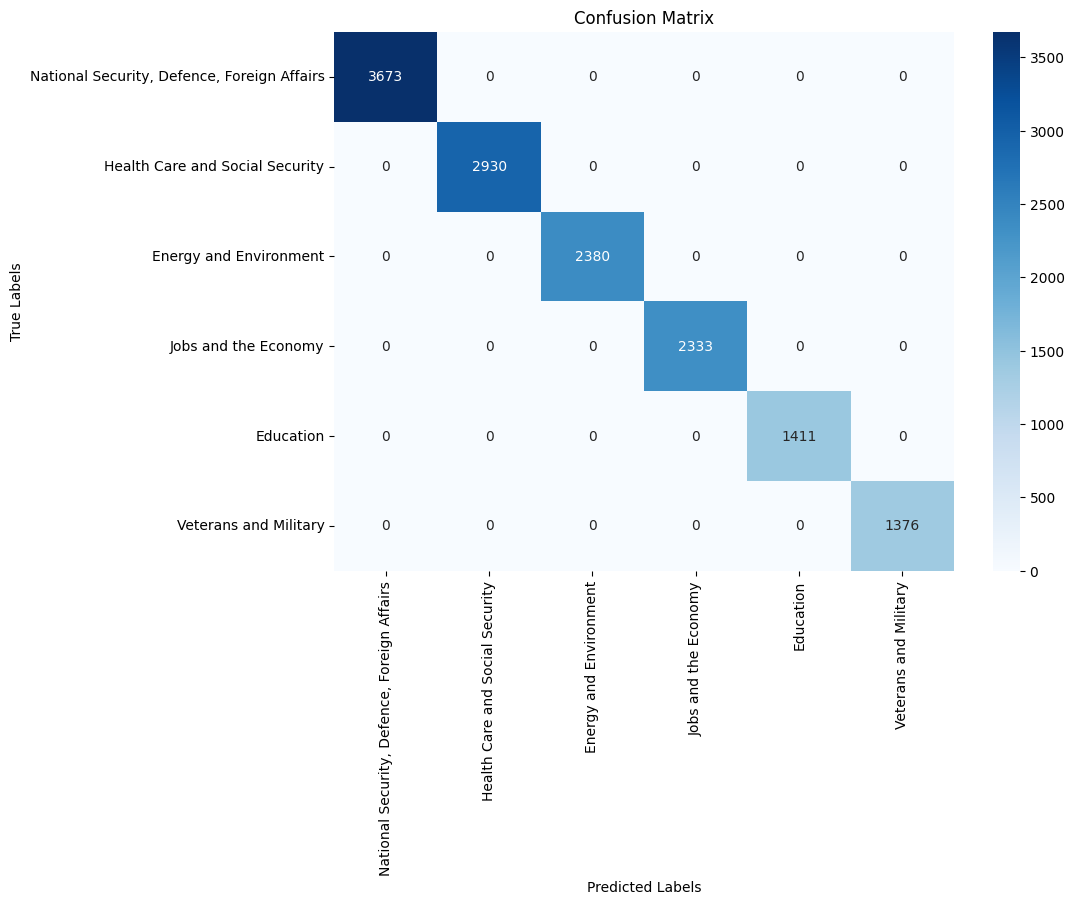

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

predictions = topics_bert
ground_truth = list(map(lambda x: topics[x], df_filtered["issue"].to_list()))

# Generate confusion matrix
cm = confusion_matrix(ground_truth, predictions)

# Display confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=topics.keys(), 
            yticklabels=topics.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
